In [9]:
from dataset import Dataset
import torch
from model import LSTMModel
import matplotlib.pyplot as plt
import os

In [10]:
train=torch.load('train4_3_dataloader.pt')
val=torch.load('val4_3_dataloader.pt')

In [11]:
loss_fn=torch.nn.CrossEntropyLoss()


Epoch:  0 Training Accuracy:  0.3491610818004658
Epoch:  0 Val Accuracy:  0.34395198522622344
Epoch:  1 Training Accuracy:  0.4726460383098056
Epoch:  1 Val Accuracy:  0.4090489381348107
Epoch:  2 Training Accuracy:  0.4709824611435905
Epoch:  2 Val Accuracy:  0.42382271468144045
Epoch:  3 Training Accuracy:  0.4907077332572841
Epoch:  3 Val Accuracy:  0.40812557710064634
Epoch:  4 Training Accuracy:  0.49493797233708825
Epoch:  4 Val Accuracy:  0.42566943674976915
Epoch:  5 Training Accuracy:  0.5164218831693521
Epoch:  5 Val Accuracy:  0.415050784856879
Epoch:  6 Training Accuracy:  0.4956984647559295
Epoch:  6 Val Accuracy:  0.41920590951061865
Epoch:  7 Training Accuracy:  0.5048719045582014
Epoch:  7 Val Accuracy:  0.4196675900277008
Epoch:  8 Training Accuracy:  0.5127620134036789
Epoch:  8 Val Accuracy:  0.4242843951985226
Epoch:  9 Training Accuracy:  0.5156138599743334
Epoch:  9 Val Accuracy:  0.402123730378578
Epoch:  10 Training Accuracy:  0.5246922382242502
Epoch:  10 Val A

KeyboardInterrupt: 

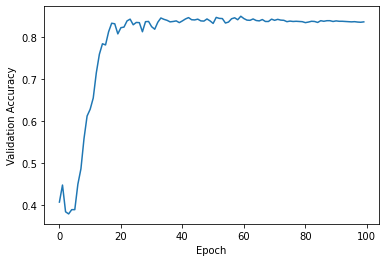

In [12]:
output_classes=4
for dropout in [0.1]:
    for layer in [3,2,4]:
            for hidden_dim in [10,16,32,64]:
                if layer==3 and hidden_dim!=64:
                    continue
                torch.manual_seed(0)
                model=LSTMModel(10,hidden_dim,layer,output_classes,dropout)
                optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
                scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.3)
                if not os.path.exists('model4_3s/0.01_'+str(dropout)+'_'+str(layer)+'_'+str(hidden_dim)):
                    os.makedirs('model4_3s/0.01_'+str(dropout)+'_'+str(layer)+'_'+str(hidden_dim))
                filename='model4_3s/0.01_'+str(dropout)+'_'+str(layer)+'_'+str(hidden_dim)
                f=open(filename+'/results.txt','w')
                loss_arr=[]
                training_accuracy=[]
                val_accuracy=[]
                for epoch in range(100):
                    model.train()
                    loss_sum=0
                    for i,(x,y) in enumerate(train):
                        optimizer.zero_grad()
                        y_pred=model(x)
                        loss=loss_fn(y_pred,y)
                        loss.backward()
                        optimizer.step()
                        loss_sum+=loss.item()
                    scheduler.step()
                    loss_sum/=len(train)
                    loss_arr.append(loss_sum)
                    model.eval()
                    correct=0
                    total=0
                    #Calculate accuracy per class 
                    accuracy_per_class=[0]*output_classes
                    fp_per_class=[0]*output_classes
                    fn_per_class=[0]*output_classes
                    tp_per_class=[0]*output_classes
                    tn_per_class=[0]*output_classes
                    fp_rate_per_class=[0]*output_classes
                    for i,(x,y) in enumerate(train):
                        y_pred=model(x)
                        _,predicted=torch.max(y_pred.data,1)
                        total+=y.size(0)
                        y=torch.max(y,1)[1]
                        correct+=(predicted==y).sum().item()
                        for i in range(len(y)):
                            if y[i]==predicted[i]:
                                tp_per_class[y[i]]+=1
                                for j in range(output_classes):
                                    if j!=y[i]:
                                        tn_per_class[j]+=1
                            else:
                                fp_per_class[predicted[i]]+=1
                                fn_per_class[y[i]]+=1
                                for j in range(output_classes):
                                    if j!=y[i] and j!=predicted[i]:
                                        tn_per_class[j]+=1
                    for i in range(output_classes):
                        fp_rate_per_class[i]=fp_per_class[i]/(fp_per_class[i]+tn_per_class[i])
                        accuracy_per_class[i]=tp_per_class[i]/(tp_per_class[i]+fn_per_class[i])
                    print('Epoch: ',epoch,'Training Accuracy: ',correct/total)
                    training_accuracy.append(correct/total)
                    f.write('Epoch: '+str(epoch)+' Training Accuracy: '+str(correct/total)+'\n')
                    f.write('Accuracy per class: '+str(accuracy_per_class)+'\n')
                    f.write('False positive rate per class: '+str(fp_rate_per_class)+'\n')
                    f.write('False positive per class: '+str(fp_per_class)+'\n')
                    f.write('False negative per class: '+str(fn_per_class)+'\n')
                    f.write('True positive per class: '+str(tp_per_class)+'\n')
                    f.write('True negative per class: '+str(tn_per_class)+'\n')
                    f.write('\n')
                    correct=0
                    total=0
                    accuracy_per_class=[0]*output_classes
                    fp_per_class=[0]*output_classes
                    fn_per_class=[0]*output_classes
                    tp_per_class=[0]*output_classes
                    tn_per_class=[0]*output_classes
                    fp_rate_per_class=[0]*output_classes
                    for i,(x,y) in enumerate(val):
                        y_pred=model(x)
                        _,predicted=torch.max(y_pred.data,1)
                        total+=y.size(0)
                        y=torch.max(y,1)[1]
                        correct+=(predicted==y).sum().item()
                        for i in range(len(y)):
                            if y[i]==predicted[i]:
                                tp_per_class[y[i]]+=1
                                for j in range(output_classes):
                                    if j!=y[i]:
                                        tn_per_class[j]+=1
                            else:
                                fp_per_class[predicted[i]]+=1
                                fn_per_class[y[i]]+=1
                                for j in range(output_classes):
                                    if j!=y[i] and j!=predicted[i]:
                                        tn_per_class[j]+=1
                    for i in range(output_classes):
                        fp_rate_per_class[i]=fp_per_class[i]/(fp_per_class[i]+tn_per_class[i])
                        if tp_per_class[i]+fn_per_class[i]==0:
                            accuracy_per_class[i]=1
                        else:
                            accuracy_per_class[i]=tp_per_class[i]/(tp_per_class[i]+fn_per_class[i])
                    print('Epoch: ',epoch,'Val Accuracy: ',correct/total)
                    val_accuracy.append(correct/total)
                    f.write('Epoch: '+str(epoch)+' Val Accuracy: '+str(correct/total)+'\n')
                    f.write('Accuracy per class: '+str(accuracy_per_class)+'\n')
                    f.write('False positive rate per class: '+str(fp_rate_per_class)+'\n')
                    f.write('False positive per class: '+str(fp_per_class)+'\n')
                    f.write('False negative per class: '+str(fn_per_class)+'\n')
                    f.write('True positive per class: '+str(tp_per_class)+'\n')
                    f.write('True negative per class: '+str(tn_per_class)+'\n')
                    f.write('\n')
                    torch.save(model,filename+'/model'+str(epoch)+'.pt')   
                plt.plot(loss_arr)
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.savefig(filename+'/loss.png')
                plt.close()
                plt.plot(training_accuracy)
                plt.xlabel('Epoch')
                plt.ylabel('Training Accuracy')
                plt.savefig(filename+'/training_accuracy.png')
                plt.close()
                plt.plot(val_accuracy)
                plt.xlabel('Epoch')
                plt.ylabel('Validation Accuracy')
                plt.savefig(filename+'/val_accuracy.png')
                f.close()

In [15]:
train=torch.load('train6_3_dataloader.pt')
val=torch.load('val6_3_dataloader.pt')

Epoch:  0 Training Accuracy:  0.2298332582244254
Epoch:  0 Val Accuracy:  0.26177285318559557
Epoch:  1 Training Accuracy:  0.2568724650743578
Epoch:  1 Val Accuracy:  0.3554939981532779
Epoch:  2 Training Accuracy:  0.26528466276100343
Epoch:  2 Val Accuracy:  0.33933518005540164
Epoch:  3 Training Accuracy:  0.2540934354814481
Epoch:  3 Val Accuracy:  0.3125577100646353
Epoch:  4 Training Accuracy:  0.25259125732311855
Epoch:  4 Val Accuracy:  0.2968605724838412
Epoch:  5 Training Accuracy:  0.2552200691001953
Epoch:  5 Val Accuracy:  0.3656509695290859
Epoch:  6 Training Accuracy:  0.249061138651044
Epoch:  6 Val Accuracy:  0.36934441366574333
Epoch:  7 Training Accuracy:  0.2857893946222022
Epoch:  7 Val Accuracy:  0.4039704524469067
Epoch:  8 Training Accuracy:  0.2857142857142857
Epoch:  8 Val Accuracy:  0.3333333333333333
Epoch:  9 Training Accuracy:  0.259726603575184
Epoch:  9 Val Accuracy:  0.38227146814404434
Epoch:  10 Training Accuracy:  0.2779780681988884
Epoch:  10 Val A

KeyboardInterrupt: 

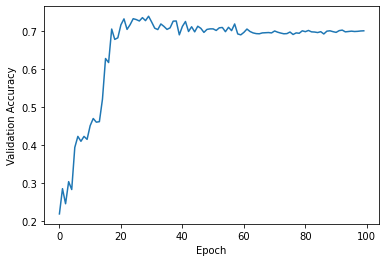

In [16]:
output_classes=6
for dropout in [0.1]:
    for layer in [3,2,4]:
            for hidden_dim in [10,16,32,64]:
                if layer==3 and hidden_dim!=64:
                    continue
                torch.manual_seed(0)
                model=LSTMModel(10,hidden_dim,layer,output_classes,dropout)
                optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
                scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.3)
                if not os.path.exists('model6_3s/0.01_'+str(dropout)+'_'+str(layer)+'_'+str(hidden_dim)):
                    os.makedirs('model6_3s/0.01_'+str(dropout)+'_'+str(layer)+'_'+str(hidden_dim))
                filename='model6_3s/0.01_'+str(dropout)+'_'+str(layer)+'_'+str(hidden_dim)
                f=open(filename+'/results.txt','w')
                loss_arr=[]
                training_accuracy=[]
                val_accuracy=[]
                for epoch in range(100):
                    model.train()
                    loss_sum=0
                    for i,(x,y) in enumerate(train):
                        optimizer.zero_grad()
                        y_pred=model(x)
                        loss=loss_fn(y_pred,y)
                        loss.backward()
                        optimizer.step()
                        loss_sum+=loss.item()
                    scheduler.step()
                    loss_sum/=len(train)
                    loss_arr.append(loss_sum)
                    model.eval()
                    correct=0
                    total=0
                    #Calculate accuracy per class 
                    accuracy_per_class=[0]*output_classes
                    fp_per_class=[0]*output_classes
                    fn_per_class=[0]*output_classes
                    tp_per_class=[0]*output_classes
                    tn_per_class=[0]*output_classes
                    fp_rate_per_class=[0]*output_classes
                    for i,(x,y) in enumerate(train):
                        y_pred=model(x)
                        _,predicted=torch.max(y_pred.data,1)
                        total+=y.size(0)
                        y=torch.max(y,1)[1]
                        correct+=(predicted==y).sum().item()
                        for i in range(len(y)):
                            if y[i]==predicted[i]:
                                tp_per_class[y[i]]+=1
                                for j in range(output_classes):
                                    if j!=y[i]:
                                        tn_per_class[j]+=1
                            else:
                                fp_per_class[predicted[i]]+=1
                                fn_per_class[y[i]]+=1
                                for j in range(output_classes):
                                    if j!=y[i] and j!=predicted[i]:
                                        tn_per_class[j]+=1
                    for i in range(output_classes):
                        fp_rate_per_class[i]=fp_per_class[i]/(fp_per_class[i]+tn_per_class[i])
                        accuracy_per_class[i]=tp_per_class[i]/(tp_per_class[i]+fn_per_class[i])
                    print('Epoch: ',epoch,'Training Accuracy: ',correct/total)
                    training_accuracy.append(correct/total)
                    f.write('Epoch: '+str(epoch)+' Training Accuracy: '+str(correct/total)+'\n')
                    f.write('Accuracy per class: '+str(accuracy_per_class)+'\n')
                    f.write('False positive rate per class: '+str(fp_rate_per_class)+'\n')
                    f.write('False positive per class: '+str(fp_per_class)+'\n')
                    f.write('False negative per class: '+str(fn_per_class)+'\n')
                    f.write('True positive per class: '+str(tp_per_class)+'\n')
                    f.write('True negative per class: '+str(tn_per_class)+'\n')
                    f.write('\n')
                    correct=0
                    total=0
                    accuracy_per_class=[0]*output_classes
                    fp_per_class=[0]*output_classes
                    fn_per_class=[0]*output_classes
                    tp_per_class=[0]*output_classes
                    tn_per_class=[0]*output_classes
                    fp_rate_per_class=[0]*output_classes
                    for i,(x,y) in enumerate(val):
                        y_pred=model(x)
                        _,predicted=torch.max(y_pred.data,1)
                        total+=y.size(0)
                        y=torch.max(y,1)[1]
                        correct+=(predicted==y).sum().item()
                        for i in range(len(y)):
                            if y[i]==predicted[i]:
                                tp_per_class[y[i]]+=1
                                for j in range(output_classes):
                                    if j!=y[i]:
                                        tn_per_class[j]+=1
                            else:
                                fp_per_class[predicted[i]]+=1
                                fn_per_class[y[i]]+=1
                                for j in range(output_classes):
                                    if j!=y[i] and j!=predicted[i]:
                                        tn_per_class[j]+=1
                    for i in range(output_classes):
                        fp_rate_per_class[i]=fp_per_class[i]/(fp_per_class[i]+tn_per_class[i])
                        if tp_per_class[i]+fn_per_class[i]==0:
                            accuracy_per_class[i]=1
                        else:
                            accuracy_per_class[i]=tp_per_class[i]/(tp_per_class[i]+fn_per_class[i])
                    print('Epoch: ',epoch,'Val Accuracy: ',correct/total)
                    val_accuracy.append(correct/total)
                    f.write('Epoch: '+str(epoch)+' Val Accuracy: '+str(correct/total)+'\n')
                    f.write('Accuracy per class: '+str(accuracy_per_class)+'\n')
                    f.write('False positive rate per class: '+str(fp_rate_per_class)+'\n')
                    f.write('False positive per class: '+str(fp_per_class)+'\n')
                    f.write('False negative per class: '+str(fn_per_class)+'\n')
                    f.write('True positive per class: '+str(tp_per_class)+'\n')
                    f.write('True negative per class: '+str(tn_per_class)+'\n')
                    f.write('\n')
                    torch.save(model,filename+'/model'+str(epoch)+'.pt')   
                plt.plot(loss_arr)
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.savefig(filename+'/loss.png')
                plt.close()
                plt.plot(training_accuracy)
                plt.xlabel('Epoch')
                plt.ylabel('Training Accuracy')
                plt.savefig(filename+'/training_accuracy.png')
                plt.close()
                plt.plot(val_accuracy)
                plt.xlabel('Epoch')
                plt.ylabel('Validation Accuracy')
                plt.savefig(filename+'/val_accuracy.png')
                f.close()